In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Flatten,MaxPooling3D,AveragePooling3D, concatenate,Input ,SpatialDropout3D,Dropout
import keras
from math import e
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from sklearn.model_selection import KFold

In [2]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
y_All=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2018-12-31'))
y_All=y_All/25.0

In [3]:
#Surface data
t2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_u10_daily_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_v10_daily_NovDecJan.nc')
# 850 Data
tuv850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_uvt_daily_NovDecJan.nc')
z850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_z_daily_NovDecJan.nc')
#700 Data
w700Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_700_w_daily_NovDecJan.nc')

In [4]:
rh = (e**((17.625*(d2mData.d2m.values-273.15))/(243.04+(d2mData.d2m.values-273.15)))/e**((17.625*(t2mData.t2m.values-273.15))/(243.04+(t2mData.t2m.values-273.15))))

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [5]:
# Calculate wind speed 
ws = ((v10Data.v10.values**2)+(u10Data.u10.values**2))**0.5
ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [6]:
#Calculate inv
inv=t2mData.t2m.values-tuv850Data.t.values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t2m - t850'

In [7]:
#u shear calculation
ushear=(tuv850Data.u.values-u10Data.u10.values)/(z850Data.z.values/9.81) 
ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})
ushear_ds.attrs['units']='s-1'
ushear_ds.attrs['long_name']='(u10 - u850)/z850'

In [8]:
# AO Input
AOData1 = xr.open_dataset('../../../Data/AO_EU/AO_Calculated.nc')
print(AOData1)

Darray=np.zeros((t2mData.time.shape[0],t2mData.latitude.shape[0], t2mData.longitude.shape[0]))
for t in range(AOData1.time.shape[0]) :
    Darray[t,:,:]=np.full((t2mData.latitude.shape[0], t2mData.longitude.shape[0]), AOData1.AO[t].values)
AOData=xr.Dataset({'AO': (('time','latitude','longitude'), Darray)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})    

<xarray.Dataset>
Dimensions:  (time: 3772)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T09:00:00 ... 2019-12-31T09:00:00
Data variables:
    AO       (time) float32 ...


In [9]:
#EU Input
EUData1 = xr.open_dataset('../../../Data/AO_EU/EU_NovDecJan.nc')
Darray=np.zeros((t2mData.time.shape[0],t2mData.latitude.shape[0], t2mData.longitude.shape[0]))
for t in range(EUData1.time.shape[0]) :
    Darray[t,:,:]=np.full((t2mData.latitude.shape[0], t2mData.longitude.shape[0]), EUData1.EUVal[t].values)
EUData=xr.Dataset({'EU': (('time','latitude','longitude'), Darray)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})    

In [10]:
t2m=t2mData.t2m.shift(time=1)
ws=ws_ds.ws.shift(time=1)
rh=rh_ds.rh.shift(time=1)
inv=inv_ds.inv.shift(time=1)
w=w700Data.w.shift(time=1)
ushear=ushear_ds.ushear.shift(time=1)
ao=AOData.AO.shift(time=1)
eu=EUData.EU.shift(time=1)

In [11]:
t2mTsAll=t2m[((t2m.time.dt.month>11) | (t2m.time.dt.month<2)) & (t2m.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wsTsAll=ws[((ws.time.dt.month>11) | (ws.time.dt.month<2)) & (ws.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
rhTsAll=rh[((rh.time.dt.month>11) | (rh.time.dt.month<2)) & (rh.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
invTsAll=inv[((inv.time.dt.month>11) | (inv.time.dt.month<2)) & (inv.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
ushearTsAll=ushear[((ushear.time.dt.month>11) | (ushear.time.dt.month<2)) & (ushear.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
aoTsAll=ao[((ao.time.dt.month>11) | (ao.time.dt.month<2)) & (ao.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
euTsAll=eu[((eu.time.dt.month>11) | (eu.time.dt.month<2)) & (eu.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wTsAll=w[((w.time.dt.month>11) | (w.time.dt.month<2)) & (w.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'),latitude=slice(35,0),longitude=slice(50,100))

In [12]:
t1=t2mTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
t2mTsAll.values=t1.unstack()

t1=wsTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wsTsAll.values=t1.unstack()

t1=rhTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
rhTsAll.values=t1.unstack()

t1=invTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
invTsAll.values=t1.unstack()

t1=ushearTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
ushearTsAll.values=t1.unstack()

t1=aoTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
aoTsAll.values=t1.unstack()

t1=euTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
euTsAll.values=t1.unstack()

t1=wTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wTsAll.values=t1.unstack()


In [13]:
t2mAll=t2mTsAll.values
t2mAll=t2mAll[:,:,:,None]
t2mAll.shape


wsAll=wsTsAll.values
wsAll=wsAll[:,:,:,None]
wsAll.shape

rhAll=rhTsAll.values
rhAll=rhAll[:,:,:,None]
rhAll.shape


invAll=invTsAll.values
invAll=invAll[:,:,:,None]
invAll.shape

wAll=wTsAll.values
wAll=wAll[:,:,:,None]
wAll.shape

ushearAll=ushearTsAll.values
ushearAll=ushearAll[:,:,:,None]
ushearAll.shape

aoAll=aoTsAll.values
aoAll=aoAll[:,:,:,None]
aoAll.shape

euAll=euTsAll.values
euAll=euAll[:,:,:,None]
euAll.shape

(2418, 18, 26, 1)

In [24]:
y=y_All.values
y=y[:,None]
y.shape

(2418, 1)

In [23]:
X=np.array([rhAll,wsAll,invAll,wAll,ushearAll,aoAll,euAll])

X = np.einsum('lkija->klija',X)
X.shape


(2418, 7, 18, 26, 1)

### KFold CV

#  LeNet-5  Architecture

Epoch 1/20
68/68 [==============================] - 9s 124ms/step - loss: 0.2722 - accuracy: 0.0481 - val_loss: 0.1667 - val_accuracy: 0.0289
Epoch 2/20
68/68 [==============================] - 8s 124ms/step - loss: 0.1583 - accuracy: 0.0597 - val_loss: 0.1456 - val_accuracy: 0.0289
Epoch 3/20
68/68 [==============================] - 8s 123ms/step - loss: 0.1287 - accuracy: 0.0469 - val_loss: 0.1199 - val_accuracy: 0.0289
Epoch 4/20
68/68 [==============================] - 9s 126ms/step - loss: 0.1214 - accuracy: 0.0484 - val_loss: 0.1171 - val_accuracy: 0.0289
Epoch 5/20
68/68 [==============================] - 8s 123ms/step - loss: 0.1069 - accuracy: 0.0497 - val_loss: 0.1024 - val_accuracy: 0.0289
Epoch 6/20
68/68 [==============================] - 8s 122ms/step - loss: 0.0958 - accuracy: 0.0508 - val_loss: 0.0997 - val_accuracy: 0.0289
Epoch 7/20
68/68 [==============================] - 9s 128ms/step - loss: 0.0884 - accuracy: 0.0474 - val_loss: 0.1006 - val_accuracy: 0.0289
Epoch 

68/68 [==============================] - 8s 125ms/step - loss: 0.0581 - accuracy: 0.0494 - val_loss: 0.0939 - val_accuracy: 0.0661
Epoch 19/20
68/68 [==============================] - 9s 126ms/step - loss: 0.0545 - accuracy: 0.0454 - val_loss: 0.0938 - val_accuracy: 0.0661
Epoch 20/20
68/68 [==============================] - 9s 126ms/step - loss: 0.0517 - accuracy: 0.0501 - val_loss: 0.0954 - val_accuracy: 0.0661
accuracy: 6.61%
Epoch 1/20
68/68 [==============================] - 9s 127ms/step - loss: 0.2632 - accuracy: 0.0490 - val_loss: 0.1695 - val_accuracy: 0.0413
Epoch 2/20
68/68 [==============================] - 9s 126ms/step - loss: 0.1567 - accuracy: 0.0542 - val_loss: 0.1511 - val_accuracy: 0.0413
Epoch 3/20
68/68 [==============================] - 9s 127ms/step - loss: 0.1384 - accuracy: 0.0561 - val_loss: 0.1378 - val_accuracy: 0.0413
Epoch 4/20
68/68 [==============================] - 9s 129ms/step - loss: 0.1196 - accuracy: 0.0529 - val_loss: 0.1193 - val_accuracy: 0.0413

68/68 [==============================] - 10s 142ms/step - loss: 0.0656 - accuracy: 0.0458 - val_loss: 0.0868 - val_accuracy: 0.0702
Epoch 16/20
68/68 [==============================] - 9s 132ms/step - loss: 0.0618 - accuracy: 0.0473 - val_loss: 0.0880 - val_accuracy: 0.0702
Epoch 17/20
68/68 [==============================] - 9s 128ms/step - loss: 0.0577 - accuracy: 0.0500 - val_loss: 0.0896 - val_accuracy: 0.0702
Epoch 18/20
68/68 [==============================] - 9s 126ms/step - loss: 0.0572 - accuracy: 0.0547 - val_loss: 0.0839 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 8s 124ms/step - loss: 0.0548 - accuracy: 0.0506 - val_loss: 0.0821 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 8s 124ms/step - loss: 0.0494 - accuracy: 0.0437 - val_loss: 0.0848 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 9s 125ms/step - loss: 0.2233 - accuracy: 0.0515 - val_loss: 0.1567 - val_accuracy: 0.

69/69 [==============================] - 8s 121ms/step - loss: 0.0795 - accuracy: 0.0502 - val_loss: 0.0940 - val_accuracy: 0.0498
Epoch 13/20
69/69 [==============================] - 9s 132ms/step - loss: 0.0668 - accuracy: 0.0529 - val_loss: 0.0960 - val_accuracy: 0.0498
Epoch 14/20
69/69 [==============================] - 9s 126ms/step - loss: 0.0684 - accuracy: 0.0531 - val_loss: 0.0999 - val_accuracy: 0.0498
Epoch 15/20
69/69 [==============================] - 8s 121ms/step - loss: 0.0711 - accuracy: 0.0544 - val_loss: 0.0954 - val_accuracy: 0.0498
Epoch 16/20
69/69 [==============================] - 8s 122ms/step - loss: 0.0622 - accuracy: 0.0493 - val_loss: 0.0969 - val_accuracy: 0.0498
Epoch 17/20
69/69 [==============================] - 8s 121ms/step - loss: 0.0611 - accuracy: 0.0507 - val_loss: 0.0980 - val_accuracy: 0.0498
Epoch 18/20
69/69 [==============================] - 8s 121ms/step - loss: 0.0741 - accuracy: 0.0452 - val_loss: 0.0997 - val_accuracy: 0.0498
Epoch 19/20

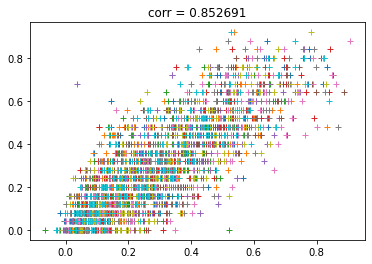

In [42]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn1 = Sequential()
    cnn1.add(Conv3D(8, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn1.add(MaxPooling3D(pool_size=2,padding='same'))
    cnn1.add(Conv3D(16, kernel_size=5, activation='relu',padding='same'))
    cnn1.add(MaxPooling3D(pool_size=2,padding='same'))

    cnn1.add(Flatten())

    cnn1.add(Dense(120, activation='relu'))
    cnn1.add(Dense(84, activation='relu'))
    cnn1.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn1.compile(optimizer='adam', loss='mae',  metrics='accuracy')
    history = cnn1.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn1.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn1.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn1.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("CNN1 LeNet-5")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    



Epoch 1/20
68/68 [==============================] - 2s 29ms/step - loss: 0.2083 - accuracy: 0.0527 - val_loss: 0.1476 - val_accuracy: 0.0289
Epoch 2/20
68/68 [==============================] - 2s 28ms/step - loss: 0.1427 - accuracy: 0.0485 - val_loss: 0.1394 - val_accuracy: 0.0289
Epoch 3/20
68/68 [==============================] - 2s 26ms/step - loss: 0.1263 - accuracy: 0.0498 - val_loss: 0.1193 - val_accuracy: 0.0289
Epoch 4/20
68/68 [==============================] - 2s 26ms/step - loss: 0.1112 - accuracy: 0.0455 - val_loss: 0.0976 - val_accuracy: 0.0289
Epoch 5/20
68/68 [==============================] - 2s 26ms/step - loss: 0.0997 - accuracy: 0.0558 - val_loss: 0.0983 - val_accuracy: 0.0289
Epoch 6/20
68/68 [==============================] - 2s 27ms/step - loss: 0.0901 - accuracy: 0.0515 - val_loss: 0.0963 - val_accuracy: 0.0289
Epoch 7/20
68/68 [==============================] - 2s 27ms/step - loss: 0.0883 - accuracy: 0.0562 - val_loss: 0.0905 - val_accuracy: 0.0289
Epoch 8/20
68

68/68 [==============================] - 2s 25ms/step - loss: 0.0492 - accuracy: 0.0507 - val_loss: 0.0872 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 2s 26ms/step - loss: 0.0492 - accuracy: 0.0455 - val_loss: 0.0858 - val_accuracy: 0.0661
Epoch 20/20
68/68 [==============================] - 2s 25ms/step - loss: 0.0457 - accuracy: 0.0504 - val_loss: 0.0812 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 4s 53ms/step - loss: 0.1887 - accuracy: 0.0478 - val_loss: 0.1734 - val_accuracy: 0.0413
Epoch 2/20
68/68 [==============================] - 2s 25ms/step - loss: 0.1651 - accuracy: 0.0510 - val_loss: 0.1426 - val_accuracy: 0.0413
Epoch 3/20
68/68 [==============================] - 2s 25ms/step - loss: 0.1446 - accuracy: 0.0569 - val_loss: 0.1221 - val_accuracy: 0.0413
Epoch 4/20
68/68 [==============================] - 2s 26ms/step - loss: 0.1250 - accuracy: 0.0574 - val_loss: 0.1141 - val_accuracy: 0.0413
Epoch 

68/68 [==============================] - 2s 26ms/step - loss: 0.0643 - accuracy: 0.0519 - val_loss: 0.0957 - val_accuracy: 0.0702
Epoch 16/20
68/68 [==============================] - 2s 25ms/step - loss: 0.0586 - accuracy: 0.0437 - val_loss: 0.0873 - val_accuracy: 0.0702
Epoch 17/20
68/68 [==============================] - 2s 25ms/step - loss: 0.0575 - accuracy: 0.0525 - val_loss: 0.0797 - val_accuracy: 0.0702
Epoch 18/20
68/68 [==============================] - 2s 26ms/step - loss: 0.0546 - accuracy: 0.0448 - val_loss: 0.0908 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 2s 25ms/step - loss: 0.0535 - accuracy: 0.0533 - val_loss: 0.0804 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 2s 26ms/step - loss: 0.0492 - accuracy: 0.0453 - val_loss: 0.0788 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 2s 27ms/step - loss: 0.1844 - accuracy: 0.0515 - val_loss: 0.1745 - val_accuracy: 0.0413
Epo

69/69 [==============================] - 2s 25ms/step - loss: 0.0892 - accuracy: 0.0583 - val_loss: 0.0981 - val_accuracy: 0.0498
Epoch 13/20
69/69 [==============================] - 2s 25ms/step - loss: 0.0783 - accuracy: 0.0473 - val_loss: 0.0935 - val_accuracy: 0.0498
Epoch 14/20
69/69 [==============================] - 2s 26ms/step - loss: 0.0719 - accuracy: 0.0482 - val_loss: 0.0946 - val_accuracy: 0.0498
Epoch 15/20
69/69 [==============================] - 2s 25ms/step - loss: 0.0688 - accuracy: 0.0521 - val_loss: 0.0969 - val_accuracy: 0.0498
Epoch 16/20
69/69 [==============================] - 2s 25ms/step - loss: 0.0697 - accuracy: 0.0509 - val_loss: 0.0967 - val_accuracy: 0.0498
Epoch 17/20
69/69 [==============================] - 2s 25ms/step - loss: 0.0597 - accuracy: 0.0548 - val_loss: 0.0921 - val_accuracy: 0.0498
Epoch 18/20
69/69 [==============================] - 2s 25ms/step - loss: 0.0602 - accuracy: 0.0474 - val_loss: 0.0889 - val_accuracy: 0.0498
Epoch 19/20
69/69 

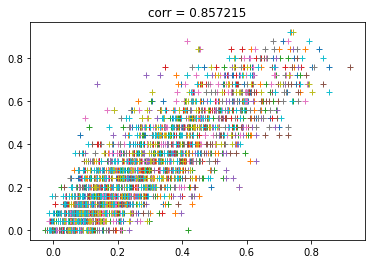

In [43]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn2 = Sequential()
    cnn2.add(Conv3D(8, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn2.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn2.add(Conv3D(16, kernel_size=5, activation='relu',padding='same'))
    cnn2.add(AveragePooling3D(pool_size=2,padding='same'))

    cnn2.add(Flatten())

    cnn2.add(Dense(120, activation='relu'))
    cnn2.add(Dense(84, activation='relu'))
    cnn2.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn2.compile(optimizer='adam', loss='mae',  metrics='accuracy')
    history = cnn2.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn2.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn2.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn2.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn2 LeNet-5 AvgPooling")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    

# Conv-Pool-Conv-Pool kind of architecture with doubling the number of filters every stage

Epoch 1/20
68/68 [==============================] - 31s 456ms/step - loss: 0.2836 - accuracy: 0.0499 - val_loss: 0.1850 - val_accuracy: 0.0289
Epoch 2/20
68/68 [==============================] - 31s 462ms/step - loss: 0.1669 - accuracy: 0.0617 - val_loss: 0.1370 - val_accuracy: 0.0289
Epoch 3/20
68/68 [==============================] - 31s 462ms/step - loss: 0.1271 - accuracy: 0.0606 - val_loss: 0.1081 - val_accuracy: 0.0289
Epoch 4/20
68/68 [==============================] - 31s 463ms/step - loss: 0.1045 - accuracy: 0.0453 - val_loss: 0.1031 - val_accuracy: 0.0289
Epoch 5/20
68/68 [==============================] - 31s 462ms/step - loss: 0.0943 - accuracy: 0.0575 - val_loss: 0.0972 - val_accuracy: 0.0289
Epoch 6/20
68/68 [==============================] - 31s 460ms/step - loss: 0.0898 - accuracy: 0.0545 - val_loss: 0.0997 - val_accuracy: 0.0289
Epoch 7/20
68/68 [==============================] - 31s 460ms/step - loss: 0.0896 - accuracy: 0.0530 - val_loss: 0.0919 - val_accuracy: 0.0289

Epoch 18/20
68/68 [==============================] - 31s 462ms/step - loss: 0.0514 - accuracy: 0.0422 - val_loss: 0.0920 - val_accuracy: 0.0661
Epoch 19/20
68/68 [==============================] - 31s 458ms/step - loss: 0.0498 - accuracy: 0.0508 - val_loss: 0.0930 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 31s 461ms/step - loss: 0.0451 - accuracy: 0.0486 - val_loss: 0.0984 - val_accuracy: 0.0661
accuracy: 6.61%
Epoch 1/20
68/68 [==============================] - 32s 465ms/step - loss: 0.3680 - accuracy: 0.0466 - val_loss: 0.1708 - val_accuracy: 0.0413
Epoch 2/20
68/68 [==============================] - 31s 461ms/step - loss: 0.1583 - accuracy: 0.0526 - val_loss: 0.1293 - val_accuracy: 0.0413
Epoch 3/20
68/68 [==============================] - 32s 464ms/step - loss: 0.1265 - accuracy: 0.0478 - val_loss: 0.1051 - val_accuracy: 0.0413
Epoch 4/20
68/68 [==============================] - 31s 461ms/step - loss: 0.1017 - accuracy: 0.0605 - val_loss: 0.1081 - v

Epoch 15/20
68/68 [==============================] - 31s 458ms/step - loss: 0.0509 - accuracy: 0.0542 - val_loss: 0.0804 - val_accuracy: 0.0702
Epoch 16/20
68/68 [==============================] - 31s 461ms/step - loss: 0.0488 - accuracy: 0.0486 - val_loss: 0.0914 - val_accuracy: 0.0702
Epoch 17/20
68/68 [==============================] - 32s 465ms/step - loss: 0.0505 - accuracy: 0.0482 - val_loss: 0.0844 - val_accuracy: 0.0702
Epoch 18/20
68/68 [==============================] - 32s 464ms/step - loss: 0.0460 - accuracy: 0.0503 - val_loss: 0.0830 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 32s 463ms/step - loss: 0.0429 - accuracy: 0.0444 - val_loss: 0.0786 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 31s 463ms/step - loss: 0.0401 - accuracy: 0.0486 - val_loss: 0.0823 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 32s 463ms/step - loss: 0.3105 - accuracy: 0.0549 - val_loss: 0.1791 

Epoch 12/20
69/69 [==============================] - 31s 451ms/step - loss: 0.0707 - accuracy: 0.0498 - val_loss: 0.0998 - val_accuracy: 0.0498
Epoch 13/20
69/69 [==============================] - 31s 452ms/step - loss: 0.0757 - accuracy: 0.0445 - val_loss: 0.0990 - val_accuracy: 0.0498
Epoch 14/20
69/69 [==============================] - 31s 455ms/step - loss: 0.0741 - accuracy: 0.0505 - val_loss: 0.0934 - val_accuracy: 0.0498
Epoch 15/20
69/69 [==============================] - 32s 458ms/step - loss: 0.0672 - accuracy: 0.0484 - val_loss: 0.0929 - val_accuracy: 0.0498
Epoch 16/20
69/69 [==============================] - 32s 458ms/step - loss: 0.0597 - accuracy: 0.0524 - val_loss: 0.0883 - val_accuracy: 0.0498
Epoch 17/20
69/69 [==============================] - 31s 456ms/step - loss: 0.0729 - accuracy: 0.0511 - val_loss: 0.0914 - val_accuracy: 0.0498
Epoch 18/20
69/69 [==============================] - 31s 453ms/step - loss: 0.0642 - accuracy: 0.0572 - val_loss: 0.0879 - val_accuracy:

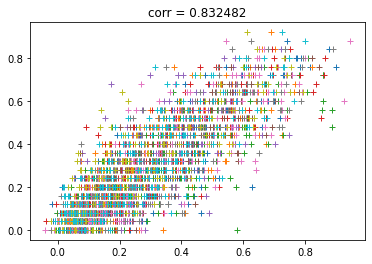

In [44]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn3 = Sequential()
    cnn3.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn3.add(MaxPooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(MaxPooling3D(pool_size=2,padding='same'))
    cnn3.add(Conv3D(128, kernel_size=3, activation='relu',padding='same'))
    cnn3.add(MaxPooling3D(pool_size=2,padding='same'))

    cnn3.add(Flatten())

    cnn3.add(Dense(64, activation='relu'))
    cnn3.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn3.compile(optimizer='adam', loss='mae',  metrics='accuracy')
    history = cnn3.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn3.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn3.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn3.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn3 Conv-Pool-Conv-Pool MaxPooling")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 1/20
68/68 [==============================] - 4s 52ms/step - loss: 0.1905 - accuracy: 0.0531 - val_loss: 0.1665 - val_accuracy: 0.0289
Epoch 2/20
68/68 [==============================] - 3s 48ms/step - loss: 0.1651 - accuracy: 0.0439 - val_loss: 0.1462 - val_accuracy: 0.0289
Epoch 3/20
68/68 [==============================] - 3s 49ms/step - loss: 0.1318 - accuracy: 0.0571 - val_loss: 0.1263 - val_accuracy: 0.0289
Epoch 4/20
68/68 [==============================] - 3s 48ms/step - loss: 0.1140 - accuracy: 0.0543 - val_loss: 0.1161 - val_accuracy: 0.0289
Epoch 5/20
68/68 [==============================] - 3s 48ms/step - loss: 0.1080 - accuracy: 0.0505 - val_loss: 0.1126 - val_accuracy: 0.0289
Epoch 6/20
68/68 [==============================] - 3s 48ms/step - loss: 0.1034 - accuracy: 0.0517 - val_loss: 0.1042 - val_accuracy: 0.0289
Epoch 7/20
68/68 [==============================] - 3s 48ms/step - loss: 0.0950 - accuracy: 0.0522 - val_loss: 0.0988 - val_accuracy: 0.0289
Epoch 8/20
68

68/68 [==============================] - 3s 48ms/step - loss: 0.0569 - accuracy: 0.0486 - val_loss: 0.0847 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 3s 48ms/step - loss: 0.0539 - accuracy: 0.0496 - val_loss: 0.0886 - val_accuracy: 0.0661
Epoch 20/20
68/68 [==============================] - 3s 49ms/step - loss: 0.0534 - accuracy: 0.0592 - val_loss: 0.0875 - val_accuracy: 0.0661
accuracy: 6.61%
Epoch 1/20
68/68 [==============================] - 4s 51ms/step - loss: 0.2091 - accuracy: 0.0550 - val_loss: 0.1806 - val_accuracy: 0.0413
Epoch 2/20
68/68 [==============================] - 3s 49ms/step - loss: 0.1756 - accuracy: 0.0472 - val_loss: 0.1797 - val_accuracy: 0.0413
Epoch 3/20
68/68 [==============================] - 3s 49ms/step - loss: 0.1715 - accuracy: 0.0458 - val_loss: 0.1547 - val_accuracy: 0.0413
Epoch 4/20
68/68 [==============================] - 3s 50ms/step - loss: 0.1457 - accuracy: 0.0459 - val_loss: 0.1320 - val_accuracy: 0.0413
Epoch 

68/68 [==============================] - 4s 59ms/step - loss: 0.0660 - accuracy: 0.0516 - val_loss: 0.0744 - val_accuracy: 0.0702
Epoch 16/20
68/68 [==============================] - 4s 60ms/step - loss: 0.0635 - accuracy: 0.0523 - val_loss: 0.0771 - val_accuracy: 0.0702
Epoch 17/20
68/68 [==============================] - 4s 61ms/step - loss: 0.0621 - accuracy: 0.0489 - val_loss: 0.0776 - val_accuracy: 0.0702
Epoch 18/20
68/68 [==============================] - 4s 61ms/step - loss: 0.0566 - accuracy: 0.0434 - val_loss: 0.0809 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 4s 60ms/step - loss: 0.0570 - accuracy: 0.0474 - val_loss: 0.0713 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 4s 59ms/step - loss: 0.0558 - accuracy: 0.0488 - val_loss: 0.0734 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 4s 55ms/step - loss: 0.1998 - accuracy: 0.0479 - val_loss: 0.1955 - val_accuracy: 0.0413
Epo

69/69 [==============================] - 3s 47ms/step - loss: 0.0815 - accuracy: 0.0557 - val_loss: 0.1020 - val_accuracy: 0.0498
Epoch 13/20
69/69 [==============================] - 3s 47ms/step - loss: 0.0884 - accuracy: 0.0543 - val_loss: 0.1089 - val_accuracy: 0.0498
Epoch 14/20
69/69 [==============================] - 3s 47ms/step - loss: 0.0791 - accuracy: 0.0525 - val_loss: 0.0888 - val_accuracy: 0.0498
Epoch 15/20
69/69 [==============================] - 3s 48ms/step - loss: 0.0711 - accuracy: 0.0479 - val_loss: 0.0939 - val_accuracy: 0.0498
Epoch 16/20
69/69 [==============================] - 3s 47ms/step - loss: 0.0808 - accuracy: 0.0541 - val_loss: 0.0880 - val_accuracy: 0.0498
Epoch 17/20
69/69 [==============================] - 3s 47ms/step - loss: 0.0700 - accuracy: 0.0442 - val_loss: 0.0965 - val_accuracy: 0.0498
Epoch 18/20
69/69 [==============================] - 3s 48ms/step - loss: 0.0672 - accuracy: 0.0506 - val_loss: 0.0914 - val_accuracy: 0.0498
Epoch 19/20
69/69 

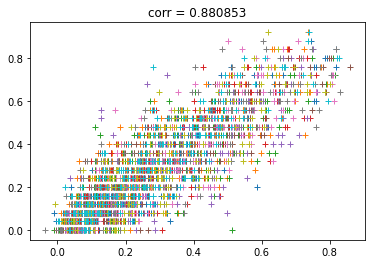

In [45]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn4 = Sequential()
    cnn4.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn4.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn4.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn4.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn4.add(Conv3D(128, kernel_size=3, activation='relu',padding='same'))
    cnn4.add(AveragePooling3D(pool_size=2,padding='same'))

    cnn4.add(Flatten())

    cnn4.add(Dense(64, activation='relu'))
    cnn4.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn4.compile(optimizer='adam', loss='mae',  metrics='accuracy')
    history = cnn4.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn4.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn4.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn4.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn4 Conv-Pool-Conv-Pool AvgPooling")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    


# a vgg like model with the trend Conv-Conv-Pool-Conv-Conv-Pool

Epoch 1/20
68/68 [==============================] - 19s 275ms/step - loss: 0.3241 - accuracy: 0.0445 - val_loss: 0.1763 - val_accuracy: 0.0289
Epoch 2/20
68/68 [==============================] - 18s 269ms/step - loss: 0.1720 - accuracy: 0.0495 - val_loss: 0.1679 - val_accuracy: 0.0289
Epoch 3/20
68/68 [==============================] - 19s 272ms/step - loss: 0.1456 - accuracy: 0.0500 - val_loss: 0.1145 - val_accuracy: 0.0289
Epoch 4/20
68/68 [==============================] - 18s 270ms/step - loss: 0.1025 - accuracy: 0.0495 - val_loss: 0.1081 - val_accuracy: 0.0289
Epoch 5/20
68/68 [==============================] - 18s 269ms/step - loss: 0.0962 - accuracy: 0.0556 - val_loss: 0.0961 - val_accuracy: 0.0289
Epoch 6/20
68/68 [==============================] - 18s 272ms/step - loss: 0.0785 - accuracy: 0.0469 - val_loss: 0.0976 - val_accuracy: 0.0289
Epoch 7/20
68/68 [==============================] - 18s 270ms/step - loss: 0.0728 - accuracy: 0.0493 - val_loss: 0.0897 - val_accuracy: 0.0289

Epoch 18/20
68/68 [==============================] - 18s 268ms/step - loss: 0.0428 - accuracy: 0.0441 - val_loss: 0.0937 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 18s 270ms/step - loss: 0.0400 - accuracy: 0.0498 - val_loss: 0.0852 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 18s 270ms/step - loss: 0.0378 - accuracy: 0.0452 - val_loss: 0.0907 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 19s 272ms/step - loss: 0.2921 - accuracy: 0.0409 - val_loss: 0.1845 - val_accuracy: 0.0413
Epoch 2/20
68/68 [==============================] - 18s 269ms/step - loss: 0.1697 - accuracy: 0.0504 - val_loss: 0.1306 - val_accuracy: 0.0413
Epoch 3/20
68/68 [==============================] - 18s 271ms/step - loss: 0.1323 - accuracy: 0.0439 - val_loss: 0.0989 - val_accuracy: 0.0413
Epoch 4/20
68/68 [==============================] - 18s 270ms/step - loss: 0.0961 - accuracy: 0.0518 - val_loss: 0.0938 - v

Epoch 15/20
68/68 [==============================] - 18s 269ms/step - loss: 0.0507 - accuracy: 0.0528 - val_loss: 0.0845 - val_accuracy: 0.0702
Epoch 16/20
68/68 [==============================] - 19s 275ms/step - loss: 0.0512 - accuracy: 0.0519 - val_loss: 0.0889 - val_accuracy: 0.0702
Epoch 17/20
68/68 [==============================] - 18s 269ms/step - loss: 0.0455 - accuracy: 0.0484 - val_loss: 0.0827 - val_accuracy: 0.0702
Epoch 18/20
68/68 [==============================] - 19s 272ms/step - loss: 0.0428 - accuracy: 0.0496 - val_loss: 0.0863 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 18s 269ms/step - loss: 0.0407 - accuracy: 0.0548 - val_loss: 0.0855 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 19s 274ms/step - loss: 0.0387 - accuracy: 0.0526 - val_loss: 0.0810 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 19s 273ms/step - loss: 0.3564 - accuracy: 0.0482 - val_loss: 0.1964 

Epoch 12/20
69/69 [==============================] - 18s 267ms/step - loss: 0.0699 - accuracy: 0.0493 - val_loss: 0.0897 - val_accuracy: 0.0498
Epoch 13/20
69/69 [==============================] - 18s 265ms/step - loss: 0.0637 - accuracy: 0.0536 - val_loss: 0.0945 - val_accuracy: 0.0498
Epoch 14/20
69/69 [==============================] - 18s 267ms/step - loss: 0.0602 - accuracy: 0.0533 - val_loss: 0.0983 - val_accuracy: 0.0498
Epoch 15/20
69/69 [==============================] - 18s 265ms/step - loss: 0.0647 - accuracy: 0.0492 - val_loss: 0.0957 - val_accuracy: 0.0498
Epoch 16/20
69/69 [==============================] - 18s 265ms/step - loss: 0.0595 - accuracy: 0.0518 - val_loss: 0.0903 - val_accuracy: 0.0498
Epoch 17/20
69/69 [==============================] - 18s 264ms/step - loss: 0.0522 - accuracy: 0.0537 - val_loss: 0.0933 - val_accuracy: 0.0498
Epoch 18/20
69/69 [==============================] - 18s 265ms/step - loss: 0.0464 - accuracy: 0.0526 - val_loss: 0.0936 - val_accuracy:

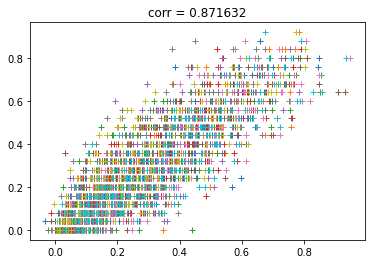

In [46]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn5 = Sequential()
    cnn5.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn5.add(Conv3D(16, kernel_size=3, activation='relu',padding='same'))
    cnn5.add(MaxPooling3D(pool_size=2,padding='same'))
    cnn5.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn5.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn5.add(MaxPooling3D(pool_size=2,padding='same'))
    

    cnn5.add(Flatten())

    cnn5.add(Dense(512, activation='relu'))
    cnn5.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn5.compile(optimizer='adam', loss='mae',  metrics='accuracy')
    history = cnn5.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn5.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn5.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn5.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn5 Vgg MaxPooling")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))    


Epoch 1/20
68/68 [==============================] - 6s 79ms/step - loss: 0.2292 - accuracy: 0.0393 - val_loss: 0.1692 - val_accuracy: 0.0289
Epoch 2/20
68/68 [==============================] - 5s 77ms/step - loss: 0.1605 - accuracy: 0.0542 - val_loss: 0.1496 - val_accuracy: 0.0289
Epoch 3/20
68/68 [==============================] - 5s 77ms/step - loss: 0.1254 - accuracy: 0.0565 - val_loss: 0.1160 - val_accuracy: 0.0289
Epoch 4/20
68/68 [==============================] - 5s 77ms/step - loss: 0.1057 - accuracy: 0.0543 - val_loss: 0.1082 - val_accuracy: 0.0289
Epoch 5/20
68/68 [==============================] - 5s 76ms/step - loss: 0.0966 - accuracy: 0.0565 - val_loss: 0.0954 - val_accuracy: 0.0289
Epoch 6/20
68/68 [==============================] - 5s 78ms/step - loss: 0.0910 - accuracy: 0.0414 - val_loss: 0.1028 - val_accuracy: 0.0289
Epoch 7/20
68/68 [==============================] - 5s 76ms/step - loss: 0.0884 - accuracy: 0.0565 - val_loss: 0.0965 - val_accuracy: 0.0289
Epoch 8/20
68

68/68 [==============================] - 5s 77ms/step - loss: 0.0447 - accuracy: 0.0553 - val_loss: 0.0867 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 5s 77ms/step - loss: 0.0433 - accuracy: 0.0497 - val_loss: 0.0870 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 5s 78ms/step - loss: 0.0431 - accuracy: 0.0438 - val_loss: 0.0893 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 6s 85ms/step - loss: 0.2375 - accuracy: 0.0434 - val_loss: 0.1843 - val_accuracy: 0.0413
Epoch 2/20
68/68 [==============================] - 5s 78ms/step - loss: 0.1778 - accuracy: 0.0471 - val_loss: 0.1830 - val_accuracy: 0.0413
Epoch 3/20
68/68 [==============================] - 5s 75ms/step - loss: 0.1663 - accuracy: 0.0489 - val_loss: 0.1616 - val_accuracy: 0.0413
Epoch 4/20
68/68 [==============================] - 5s 76ms/step - loss: 0.1495 - accuracy: 0.0512 - val_loss: 0.1294 - val_accuracy: 0.0413
Epoch 

68/68 [==============================] - 5s 75ms/step - loss: 0.0520 - accuracy: 0.0503 - val_loss: 0.0789 - val_accuracy: 0.0702
Epoch 16/20
68/68 [==============================] - 5s 76ms/step - loss: 0.0485 - accuracy: 0.0423 - val_loss: 0.0792 - val_accuracy: 0.0702
Epoch 17/20
68/68 [==============================] - 5s 78ms/step - loss: 0.0446 - accuracy: 0.0517 - val_loss: 0.0791 - val_accuracy: 0.0702
Epoch 18/20
68/68 [==============================] - 5s 79ms/step - loss: 0.0426 - accuracy: 0.0534 - val_loss: 0.0862 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 5s 76ms/step - loss: 0.0425 - accuracy: 0.0485 - val_loss: 0.0800 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 5s 78ms/step - loss: 0.0376 - accuracy: 0.0505 - val_loss: 0.0733 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 6s 79ms/step - loss: 0.2475 - accuracy: 0.0466 - val_loss: 0.2060 - val_accuracy: 0.0413
Epo

69/69 [==============================] - 5s 77ms/step - loss: 0.0664 - accuracy: 0.0572 - val_loss: 0.0988 - val_accuracy: 0.0498
Epoch 13/20
69/69 [==============================] - 5s 76ms/step - loss: 0.0818 - accuracy: 0.0541 - val_loss: 0.0893 - val_accuracy: 0.0498
Epoch 14/20
69/69 [==============================] - 5s 76ms/step - loss: 0.0698 - accuracy: 0.0482 - val_loss: 0.0812 - val_accuracy: 0.0498
Epoch 15/20
69/69 [==============================] - 5s 75ms/step - loss: 0.0639 - accuracy: 0.0492 - val_loss: 0.0833 - val_accuracy: 0.0498
Epoch 16/20
69/69 [==============================] - 5s 76ms/step - loss: 0.0578 - accuracy: 0.0469 - val_loss: 0.0887 - val_accuracy: 0.0498
Epoch 17/20
69/69 [==============================] - 5s 76ms/step - loss: 0.0622 - accuracy: 0.0567 - val_loss: 0.0845 - val_accuracy: 0.0498
Epoch 18/20
69/69 [==============================] - 5s 77ms/step - loss: 0.0535 - accuracy: 0.0487 - val_loss: 0.0820 - val_accuracy: 0.0498
Epoch 19/20
69/69 

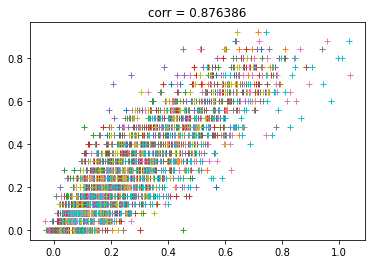

In [47]:
# define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn6 = Sequential()
    cnn6.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn6.add(Conv3D(16, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    

    cnn6.add(Flatten())

    cnn6.add(Dense(512, activation='relu'))
    cnn6.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn6.compile(optimizer='adam', loss='mae',  metrics='accuracy')
    history = cnn6.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn6.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn6.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn6.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn6 Vgg AveragePooling")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) 

In [ ]:
# Kernel 16,32 and dropout 0.2 lr=0.001

Epoch 1/20
68/68 [==============================] - 7s 87ms/step - loss: 0.2552 - accuracy: 0.0493 - val_loss: 0.1748 - val_accuracy: 0.0289
Epoch 2/20
68/68 [==============================] - 6s 84ms/step - loss: 0.1704 - accuracy: 0.0537 - val_loss: 0.1736 - val_accuracy: 0.0289
Epoch 3/20
68/68 [==============================] - 6s 85ms/step - loss: 0.1611 - accuracy: 0.0477 - val_loss: 0.1406 - val_accuracy: 0.0289
Epoch 4/20
68/68 [==============================] - 6s 84ms/step - loss: 0.1359 - accuracy: 0.0489 - val_loss: 0.1210 - val_accuracy: 0.0289
Epoch 5/20
68/68 [==============================] - 6s 85ms/step - loss: 0.1151 - accuracy: 0.0651 - val_loss: 0.1044 - val_accuracy: 0.0289
Epoch 6/20
68/68 [==============================] - 6s 84ms/step - loss: 0.1021 - accuracy: 0.0527 - val_loss: 0.1008 - val_accuracy: 0.0289
Epoch 7/20
68/68 [==============================] - 6s 85ms/step - loss: 0.1027 - accuracy: 0.0438 - val_loss: 0.0961 - val_accuracy: 0.0289
Epoch 8/20
68

68/68 [==============================] - 6s 85ms/step - loss: 0.0662 - accuracy: 0.0536 - val_loss: 0.0811 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 6s 83ms/step - loss: 0.0666 - accuracy: 0.0503 - val_loss: 0.0852 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 6s 83ms/step - loss: 0.0654 - accuracy: 0.0452 - val_loss: 0.0878 - val_accuracy: 0.0661
accuracy: 6.61%
Epoch 1/20
68/68 [==============================] - 6s 86ms/step - loss: 0.2551 - accuracy: 0.0455 - val_loss: 0.1809 - val_accuracy: 0.0413
Epoch 2/20
68/68 [==============================] - 6s 85ms/step - loss: 0.1679 - accuracy: 0.0467 - val_loss: 0.1761 - val_accuracy: 0.0413
Epoch 3/20
68/68 [==============================] - 6s 84ms/step - loss: 0.1725 - accuracy: 0.0600 - val_loss: 0.1429 - val_accuracy: 0.0413
Epoch 4/20
68/68 [==============================] - 6s 84ms/step - loss: 0.1352 - accuracy: 0.0524 - val_loss: 0.1276 - val_accuracy: 0.0413
Epoch 

68/68 [==============================] - 6s 87ms/step - loss: 0.0830 - accuracy: 0.0502 - val_loss: 0.0782 - val_accuracy: 0.0702
Epoch 16/20
68/68 [==============================] - 6s 88ms/step - loss: 0.0823 - accuracy: 0.0396 - val_loss: 0.0836 - val_accuracy: 0.0702
Epoch 17/20
68/68 [==============================] - 6s 88ms/step - loss: 0.0785 - accuracy: 0.0393 - val_loss: 0.0832 - val_accuracy: 0.0702
Epoch 18/20
68/68 [==============================] - 6s 87ms/step - loss: 0.0726 - accuracy: 0.0440 - val_loss: 0.0789 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 6s 87ms/step - loss: 0.0703 - accuracy: 0.0498 - val_loss: 0.0821 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 6s 87ms/step - loss: 0.0670 - accuracy: 0.0539 - val_loss: 0.0811 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 7s 94ms/step - loss: 0.2004 - accuracy: 0.0512 - val_loss: 0.2064 - val_accuracy: 0.0413
Epo

69/69 [==============================] - 5s 79ms/step - loss: 0.0885 - accuracy: 0.0439 - val_loss: 0.0904 - val_accuracy: 0.0498
Epoch 13/20
69/69 [==============================] - 5s 80ms/step - loss: 0.0869 - accuracy: 0.0572 - val_loss: 0.0907 - val_accuracy: 0.0498
Epoch 14/20
69/69 [==============================] - 6s 81ms/step - loss: 0.0839 - accuracy: 0.0611 - val_loss: 0.0881 - val_accuracy: 0.0498
Epoch 15/20
69/69 [==============================] - 6s 83ms/step - loss: 0.0802 - accuracy: 0.0512 - val_loss: 0.0882 - val_accuracy: 0.0498
Epoch 16/20
69/69 [==============================] - 6s 87ms/step - loss: 0.0820 - accuracy: 0.0529 - val_loss: 0.0852 - val_accuracy: 0.0498
Epoch 17/20
69/69 [==============================] - 6s 80ms/step - loss: 0.0816 - accuracy: 0.0510 - val_loss: 0.0897 - val_accuracy: 0.0498
Epoch 18/20
69/69 [==============================] - 6s 81ms/step - loss: 0.0802 - accuracy: 0.0473 - val_loss: 0.0911 - val_accuracy: 0.0498
Epoch 19/20
69/69 

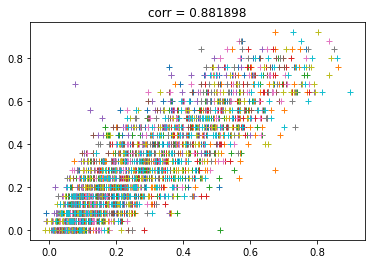

In [49]:
# # define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn6 = Sequential()
    cnn6.add(Conv3D(16, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn6.add(Conv3D(16, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))

    cnn6.add(Flatten())

    cnn6.add(Dense(512, activation='relu'))
    cnn6.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn6.compile(optimizer='adam', loss='mae',  metrics='accuracy')
    history = cnn6.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn6.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn6.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn6.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn6 Vgg AveragePooling Kernel 16,32 and dropout 0.2 lr=0.001")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) 

In [50]:
# Kernel 32,64 and dropout 0.2 lr=0.001

Epoch 1/20
68/68 [==============================] - 13s 190ms/step - loss: 0.3060 - accuracy: 0.0481 - val_loss: 0.1776 - val_accuracy: 0.0289
Epoch 2/20
68/68 [==============================] - 13s 190ms/step - loss: 0.1738 - accuracy: 0.0586 - val_loss: 0.1641 - val_accuracy: 0.0289
Epoch 3/20
68/68 [==============================] - 13s 189ms/step - loss: 0.1525 - accuracy: 0.0488 - val_loss: 0.1198 - val_accuracy: 0.0289
Epoch 4/20
68/68 [==============================] - 13s 189ms/step - loss: 0.1241 - accuracy: 0.0620 - val_loss: 0.1063 - val_accuracy: 0.0289
Epoch 5/20
68/68 [==============================] - 13s 187ms/step - loss: 0.1095 - accuracy: 0.0539 - val_loss: 0.1014 - val_accuracy: 0.0289
Epoch 6/20
68/68 [==============================] - 13s 189ms/step - loss: 0.0978 - accuracy: 0.0560 - val_loss: 0.0965 - val_accuracy: 0.0289
Epoch 7/20
68/68 [==============================] - 13s 186ms/step - loss: 0.0984 - accuracy: 0.0525 - val_loss: 0.0990 - val_accuracy: 0.0289

Epoch 18/20
68/68 [==============================] - 13s 198ms/step - loss: 0.0723 - accuracy: 0.0504 - val_loss: 0.0957 - val_accuracy: 0.0661
Epoch 19/20
68/68 [==============================] - 13s 193ms/step - loss: 0.0737 - accuracy: 0.0480 - val_loss: 0.0971 - val_accuracy: 0.0661
Epoch 20/20
68/68 [==============================] - 13s 191ms/step - loss: 0.0690 - accuracy: 0.0497 - val_loss: 0.0836 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 13s 192ms/step - loss: 0.3184 - accuracy: 0.0442 - val_loss: 0.1827 - val_accuracy: 0.0413
Epoch 2/20
68/68 [==============================] - 13s 190ms/step - loss: 0.1729 - accuracy: 0.0509 - val_loss: 0.1786 - val_accuracy: 0.0413
Epoch 3/20
68/68 [==============================] - 13s 189ms/step - loss: 0.1717 - accuracy: 0.0572 - val_loss: 0.1572 - val_accuracy: 0.0413
Epoch 4/20
68/68 [==============================] - 13s 193ms/step - loss: 0.1438 - accuracy: 0.0491 - val_loss: 0.1200 - v

Epoch 15/20
68/68 [==============================] - 13s 190ms/step - loss: 0.0821 - accuracy: 0.0450 - val_loss: 0.0808 - val_accuracy: 0.0702
Epoch 16/20
68/68 [==============================] - 13s 189ms/step - loss: 0.0830 - accuracy: 0.0520 - val_loss: 0.0842 - val_accuracy: 0.0702
Epoch 17/20
68/68 [==============================] - 13s 190ms/step - loss: 0.0771 - accuracy: 0.0517 - val_loss: 0.0791 - val_accuracy: 0.0702
Epoch 18/20
68/68 [==============================] - 13s 191ms/step - loss: 0.0738 - accuracy: 0.0484 - val_loss: 0.0813 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 13s 187ms/step - loss: 0.0766 - accuracy: 0.0487 - val_loss: 0.0815 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 13s 184ms/step - loss: 0.0761 - accuracy: 0.0574 - val_loss: 0.0833 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 13s 191ms/step - loss: 0.2503 - accuracy: 0.0427 - val_loss: 0.2107 

Epoch 12/20
69/69 [==============================] - 12s 179ms/step - loss: 0.0932 - accuracy: 0.0530 - val_loss: 0.1007 - val_accuracy: 0.0498
Epoch 13/20
69/69 [==============================] - 12s 179ms/step - loss: 0.0972 - accuracy: 0.0483 - val_loss: 0.0944 - val_accuracy: 0.0498
Epoch 14/20
69/69 [==============================] - 12s 179ms/step - loss: 0.0908 - accuracy: 0.0495 - val_loss: 0.1028 - val_accuracy: 0.0498
Epoch 15/20
69/69 [==============================] - 12s 179ms/step - loss: 0.0943 - accuracy: 0.0536 - val_loss: 0.0943 - val_accuracy: 0.0498
Epoch 16/20
69/69 [==============================] - 12s 178ms/step - loss: 0.0857 - accuracy: 0.0589 - val_loss: 0.0939 - val_accuracy: 0.0498
Epoch 17/20
69/69 [==============================] - 12s 178ms/step - loss: 0.0882 - accuracy: 0.0476 - val_loss: 0.0898 - val_accuracy: 0.0498
Epoch 18/20
69/69 [==============================] - 12s 180ms/step - loss: 0.0798 - accuracy: 0.0504 - val_loss: 0.1018 - val_accuracy:

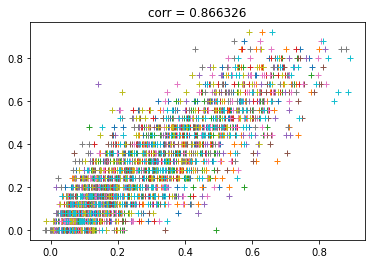

In [51]:
# # define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn6 = Sequential()
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))

    cnn6.add(Flatten())

    cnn6.add(Dense(512, activation='relu'))
    cnn6.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn6.compile(optimizer='adam', loss='mae',  metrics='accuracy')
    history = cnn6.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn6.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn6.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn6.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn6 Vgg AveragePooling Kernel 32,64 and dropout 0.2 lr=0.001")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) 

In [52]:
# Kernel 32,64 and dropout 0.2 lr=0.001 dense 256

Epoch 1/20
68/68 [==============================] - 16s 196ms/step - loss: 0.2453 - accuracy: 0.0429 - val_loss: 0.1788 - val_accuracy: 0.0289
Epoch 2/20
68/68 [==============================] - 12s 182ms/step - loss: 0.1777 - accuracy: 0.0575 - val_loss: 0.1753 - val_accuracy: 0.0289
Epoch 3/20
68/68 [==============================] - 13s 184ms/step - loss: 0.1810 - accuracy: 0.0580 - val_loss: 0.1758 - val_accuracy: 0.0289
Epoch 4/20
68/68 [==============================] - 12s 179ms/step - loss: 0.1741 - accuracy: 0.0574 - val_loss: 0.1879 - val_accuracy: 0.0289
Epoch 5/20
68/68 [==============================] - 12s 178ms/step - loss: 0.1494 - accuracy: 0.0556 - val_loss: 0.1330 - val_accuracy: 0.0289
Epoch 6/20
68/68 [==============================] - 12s 182ms/step - loss: 0.1345 - accuracy: 0.0539 - val_loss: 0.1139 - val_accuracy: 0.0289
Epoch 7/20
68/68 [==============================] - 12s 182ms/step - loss: 0.1170 - accuracy: 0.0616 - val_loss: 0.1053 - val_accuracy: 0.0289

Epoch 18/20
68/68 [==============================] - 11s 167ms/step - loss: 0.0690 - accuracy: 0.0481 - val_loss: 0.0862 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 11s 166ms/step - loss: 0.0678 - accuracy: 0.0467 - val_loss: 0.0927 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 11s 168ms/step - loss: 0.0655 - accuracy: 0.0600 - val_loss: 0.0909 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 12s 168ms/step - loss: 0.2337 - accuracy: 0.0487 - val_loss: 0.1811 - val_accuracy: 0.0413
Epoch 2/20
68/68 [==============================] - 11s 168ms/step - loss: 0.1707 - accuracy: 0.0497 - val_loss: 0.1755 - val_accuracy: 0.0413
Epoch 3/20
68/68 [==============================] - 11s 165ms/step - loss: 0.1587 - accuracy: 0.0482 - val_loss: 0.1602 - val_accuracy: 0.0413
Epoch 4/20
68/68 [==============================] - 11s 169ms/step - loss: 0.1352 - accuracy: 0.0464 - val_loss: 0.1176 - v

Epoch 15/20
68/68 [==============================] - 11s 167ms/step - loss: 0.0782 - accuracy: 0.0477 - val_loss: 0.0794 - val_accuracy: 0.0702
Epoch 16/20
68/68 [==============================] - 11s 169ms/step - loss: 0.0736 - accuracy: 0.0554 - val_loss: 0.0775 - val_accuracy: 0.0702
Epoch 17/20
68/68 [==============================] - 11s 169ms/step - loss: 0.0717 - accuracy: 0.0482 - val_loss: 0.0747 - val_accuracy: 0.0702
Epoch 18/20
68/68 [==============================] - 12s 172ms/step - loss: 0.0688 - accuracy: 0.0463 - val_loss: 0.0714 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 12s 170ms/step - loss: 0.0695 - accuracy: 0.0469 - val_loss: 0.0801 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 12s 170ms/step - loss: 0.0699 - accuracy: 0.0560 - val_loss: 0.0754 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 12s 172ms/step - loss: 0.2373 - accuracy: 0.0467 - val_loss: 0.1935 

Epoch 12/20
69/69 [==============================] - 12s 168ms/step - loss: 0.0930 - accuracy: 0.0522 - val_loss: 0.0917 - val_accuracy: 0.0498
Epoch 13/20
69/69 [==============================] - 12s 170ms/step - loss: 0.0946 - accuracy: 0.0543 - val_loss: 0.0928 - val_accuracy: 0.0498
Epoch 14/20
69/69 [==============================] - 12s 170ms/step - loss: 0.0877 - accuracy: 0.0523 - val_loss: 0.0908 - val_accuracy: 0.0498
Epoch 15/20
69/69 [==============================] - 12s 169ms/step - loss: 0.0804 - accuracy: 0.0552 - val_loss: 0.0938 - val_accuracy: 0.0498
Epoch 16/20
69/69 [==============================] - 12s 171ms/step - loss: 0.0819 - accuracy: 0.0570 - val_loss: 0.0909 - val_accuracy: 0.0498
Epoch 17/20
69/69 [==============================] - 12s 169ms/step - loss: 0.0775 - accuracy: 0.0586 - val_loss: 0.0933 - val_accuracy: 0.0498
Epoch 18/20
69/69 [==============================] - 12s 167ms/step - loss: 0.0866 - accuracy: 0.0439 - val_loss: 0.0893 - val_accuracy:

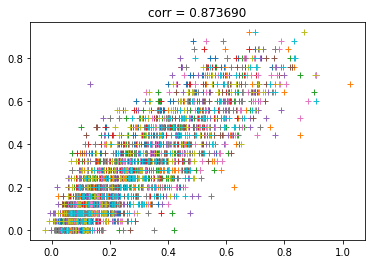

In [53]:
 # define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn6 = Sequential()
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))

    cnn6.add(Flatten())

    cnn6.add(Dense(256, activation='relu'))
    cnn6.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn6.compile(optimizer='adam', loss='mae',  metrics='accuracy')
    history = cnn6.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn6.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn6.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn6.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn6 Vgg AveragePooling Kernel 32,64 and dropout 0.2 dense 256 lr=0.001")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) 

In [54]:
# cnn6 Vgg AveragePooling Kernel 32,64 and dropout 0.2 dense 1024 lr=0.001

Epoch 1/20
68/68 [==============================] - 12s 174ms/step - loss: 0.3037 - accuracy: 0.0490 - val_loss: 0.1758 - val_accuracy: 0.0289
Epoch 2/20
68/68 [==============================] - 12s 173ms/step - loss: 0.1746 - accuracy: 0.0609 - val_loss: 0.1743 - val_accuracy: 0.0289
Epoch 3/20
68/68 [==============================] - 12s 174ms/step - loss: 0.1714 - accuracy: 0.0574 - val_loss: 0.1640 - val_accuracy: 0.0289
Epoch 4/20
68/68 [==============================] - 12s 171ms/step - loss: 0.1498 - accuracy: 0.0533 - val_loss: 0.1181 - val_accuracy: 0.0289
Epoch 5/20
68/68 [==============================] - 12s 173ms/step - loss: 0.1213 - accuracy: 0.0517 - val_loss: 0.1065 - val_accuracy: 0.0289
Epoch 6/20
68/68 [==============================] - 12s 172ms/step - loss: 0.1156 - accuracy: 0.0600 - val_loss: 0.1059 - val_accuracy: 0.0289
Epoch 7/20
68/68 [==============================] - 12s 178ms/step - loss: 0.1072 - accuracy: 0.0493 - val_loss: 0.0967 - val_accuracy: 0.0289

Epoch 18/20
68/68 [==============================] - 12s 173ms/step - loss: 0.0728 - accuracy: 0.0520 - val_loss: 0.0887 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 12s 172ms/step - loss: 0.0732 - accuracy: 0.0478 - val_loss: 0.0879 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 12s 173ms/step - loss: 0.0704 - accuracy: 0.0599 - val_loss: 0.0886 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 12s 174ms/step - loss: 0.2811 - accuracy: 0.0402 - val_loss: 0.1839 - val_accuracy: 0.0413
Epoch 2/20
68/68 [==============================] - 12s 173ms/step - loss: 0.1725 - accuracy: 0.0532 - val_loss: 0.1808 - val_accuracy: 0.0413
Epoch 3/20
68/68 [==============================] - 12s 174ms/step - loss: 0.1718 - accuracy: 0.0525 - val_loss: 0.1801 - val_accuracy: 0.0413
Epoch 4/20
68/68 [==============================] - 12s 175ms/step - loss: 0.1697 - accuracy: 0.0597 - val_loss: 0.1422 - v

Epoch 15/20
68/68 [==============================] - 12s 174ms/step - loss: 0.0839 - accuracy: 0.0520 - val_loss: 0.0776 - val_accuracy: 0.0702
Epoch 16/20
68/68 [==============================] - 12s 175ms/step - loss: 0.0813 - accuracy: 0.0446 - val_loss: 0.0825 - val_accuracy: 0.0702
Epoch 17/20
68/68 [==============================] - 12s 171ms/step - loss: 0.0763 - accuracy: 0.0466 - val_loss: 0.0800 - val_accuracy: 0.0702
Epoch 18/20
68/68 [==============================] - 12s 175ms/step - loss: 0.0736 - accuracy: 0.0477 - val_loss: 0.0882 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 13s 185ms/step - loss: 0.0803 - accuracy: 0.0428 - val_loss: 0.0771 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 12s 181ms/step - loss: 0.0711 - accuracy: 0.0490 - val_loss: 0.0768 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 13s 186ms/step - loss: 0.3479 - accuracy: 0.0528 - val_loss: 0.1939 

Epoch 12/20
69/69 [==============================] - 12s 169ms/step - loss: 0.0830 - accuracy: 0.0501 - val_loss: 0.0909 - val_accuracy: 0.0498
Epoch 13/20
69/69 [==============================] - 12s 168ms/step - loss: 0.0889 - accuracy: 0.0573 - val_loss: 0.0903 - val_accuracy: 0.0498
Epoch 14/20
69/69 [==============================] - 12s 170ms/step - loss: 0.0807 - accuracy: 0.0528 - val_loss: 0.0908 - val_accuracy: 0.0498
Epoch 15/20
69/69 [==============================] - 12s 170ms/step - loss: 0.0786 - accuracy: 0.0450 - val_loss: 0.0886 - val_accuracy: 0.0498
Epoch 16/20
69/69 [==============================] - 12s 171ms/step - loss: 0.0734 - accuracy: 0.0491 - val_loss: 0.0907 - val_accuracy: 0.0498
Epoch 17/20
69/69 [==============================] - 12s 170ms/step - loss: 0.0842 - accuracy: 0.0491 - val_loss: 0.0909 - val_accuracy: 0.0498
Epoch 18/20
69/69 [==============================] - 12s 169ms/step - loss: 0.0764 - accuracy: 0.0517 - val_loss: 0.0915 - val_accuracy:

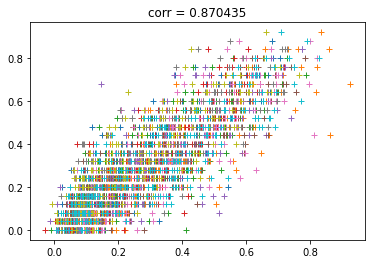

In [55]:
 # define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn6 = Sequential()
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))

    cnn6.add(Flatten())

    cnn6.add(Dense(1024, activation='relu'))
    cnn6.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.001)
    cnn6.compile(optimizer='adam', loss='mae',  metrics='accuracy')
    history = cnn6.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn6.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn6.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn6.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn6 Vgg AveragePooling Kernel 32,64 and dropout 0.2 dense 1024 lr=0.001")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) 

Epoch 1/20
68/68 [==============================] - 14s 175ms/step - loss: 0.3054 - accuracy: 0.0412 - val_loss: 0.1799 - val_accuracy: 0.0289
Epoch 2/20
68/68 [==============================] - 12s 170ms/step - loss: 0.1758 - accuracy: 0.0567 - val_loss: 0.1748 - val_accuracy: 0.0289
Epoch 3/20
68/68 [==============================] - 12s 170ms/step - loss: 0.1729 - accuracy: 0.0513 - val_loss: 0.1777 - val_accuracy: 0.0289
Epoch 4/20
68/68 [==============================] - 11s 166ms/step - loss: 0.1740 - accuracy: 0.0589 - val_loss: 0.1553 - val_accuracy: 0.0289
Epoch 5/20
68/68 [==============================] - 11s 168ms/step - loss: 0.1414 - accuracy: 0.0595 - val_loss: 0.1162 - val_accuracy: 0.0289
Epoch 6/20
68/68 [==============================] - 12s 174ms/step - loss: 0.1218 - accuracy: 0.0497 - val_loss: 0.1085 - val_accuracy: 0.0289
Epoch 7/20
68/68 [==============================] - 12s 171ms/step - loss: 0.1074 - accuracy: 0.0598 - val_loss: 0.1060 - val_accuracy: 0.0289

Epoch 18/20
68/68 [==============================] - 12s 171ms/step - loss: 0.0720 - accuracy: 0.0481 - val_loss: 0.0906 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 12s 170ms/step - loss: 0.0676 - accuracy: 0.0435 - val_loss: 0.0844 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 12s 171ms/step - loss: 0.0671 - accuracy: 0.0498 - val_loss: 0.0935 - val_accuracy: 0.0661
accuracy: 6.61%
Epoch 1/20
68/68 [==============================] - 12s 172ms/step - loss: 0.2823 - accuracy: 0.0452 - val_loss: 0.1804 - val_accuracy: 0.0413
Epoch 2/20
68/68 [==============================] - 12s 171ms/step - loss: 0.1690 - accuracy: 0.0557 - val_loss: 0.1602 - val_accuracy: 0.0413
Epoch 3/20
68/68 [==============================] - 12s 171ms/step - loss: 0.1472 - accuracy: 0.0539 - val_loss: 0.1266 - val_accuracy: 0.0413
Epoch 4/20
68/68 [==============================] - 12s 170ms/step - loss: 0.1244 - accuracy: 0.0467 - val_loss: 0.1186 - v

Epoch 15/20
68/68 [==============================] - 12s 170ms/step - loss: 0.0717 - accuracy: 0.0493 - val_loss: 0.0745 - val_accuracy: 0.0702
Epoch 16/20
68/68 [==============================] - 12s 170ms/step - loss: 0.0700 - accuracy: 0.0550 - val_loss: 0.0806 - val_accuracy: 0.0702
Epoch 17/20
68/68 [==============================] - 12s 176ms/step - loss: 0.0700 - accuracy: 0.0544 - val_loss: 0.0795 - val_accuracy: 0.0702
Epoch 18/20
68/68 [==============================] - 12s 174ms/step - loss: 0.0685 - accuracy: 0.0515 - val_loss: 0.0722 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 12s 177ms/step - loss: 0.0636 - accuracy: 0.0490 - val_loss: 0.0737 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 12s 174ms/step - loss: 0.0631 - accuracy: 0.0554 - val_loss: 0.0750 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 12s 177ms/step - loss: 0.2409 - accuracy: 0.0505 - val_loss: 0.2027 

Epoch 12/20
69/69 [==============================] - 11s 164ms/step - loss: 0.0882 - accuracy: 0.0534 - val_loss: 0.0937 - val_accuracy: 0.0498
Epoch 13/20
69/69 [==============================] - 11s 166ms/step - loss: 0.0838 - accuracy: 0.0514 - val_loss: 0.0944 - val_accuracy: 0.0498
Epoch 14/20
69/69 [==============================] - 11s 166ms/step - loss: 0.0828 - accuracy: 0.0486 - val_loss: 0.0937 - val_accuracy: 0.0498
Epoch 15/20
69/69 [==============================] - 11s 165ms/step - loss: 0.0822 - accuracy: 0.0564 - val_loss: 0.0908 - val_accuracy: 0.0498
Epoch 16/20
69/69 [==============================] - 12s 167ms/step - loss: 0.0838 - accuracy: 0.0516 - val_loss: 0.0856 - val_accuracy: 0.0498
Epoch 17/20
69/69 [==============================] - 11s 165ms/step - loss: 0.0794 - accuracy: 0.0437 - val_loss: 0.0916 - val_accuracy: 0.0498
Epoch 18/20
69/69 [==============================] - 11s 165ms/step - loss: 0.0722 - accuracy: 0.0552 - val_loss: 0.0864 - val_accuracy:

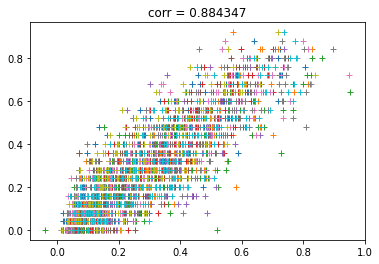

In [56]:
 # define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn6 = Sequential()
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))

    cnn6.add(Flatten())

    cnn6.add(Dense(256, activation='relu'))
    cnn6.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.01)
    cnn6.compile(optimizer='adam', loss='mae',  metrics='accuracy')
    history = cnn6.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn6.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn6.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn6.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn6 Vgg AveragePooling Kernel 32,64 and dropout 0.2 dense 256 lr=0.01")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) 

Epoch 1/20
68/68 [==============================] - 12s 178ms/step - loss: 0.2224 - accuracy: 0.0552 - val_loss: 0.1804 - val_accuracy: 0.0289
Epoch 2/20
68/68 [==============================] - 12s 177ms/step - loss: 0.1754 - accuracy: 0.0531 - val_loss: 0.1748 - val_accuracy: 0.0289
Epoch 3/20
68/68 [==============================] - 12s 178ms/step - loss: 0.1659 - accuracy: 0.0489 - val_loss: 0.1312 - val_accuracy: 0.0289
Epoch 4/20
68/68 [==============================] - 12s 178ms/step - loss: 0.1267 - accuracy: 0.0532 - val_loss: 0.1196 - val_accuracy: 0.0289
Epoch 5/20
68/68 [==============================] - 12s 177ms/step - loss: 0.1124 - accuracy: 0.0538 - val_loss: 0.1046 - val_accuracy: 0.0289
Epoch 6/20
68/68 [==============================] - 12s 175ms/step - loss: 0.1062 - accuracy: 0.0517 - val_loss: 0.1040 - val_accuracy: 0.0289
Epoch 7/20
68/68 [==============================] - 12s 180ms/step - loss: 0.1020 - accuracy: 0.0551 - val_loss: 0.1057 - val_accuracy: 0.0289

Epoch 18/20
68/68 [==============================] - 12s 178ms/step - loss: 0.0756 - accuracy: 0.0465 - val_loss: 0.0890 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 12s 178ms/step - loss: 0.0724 - accuracy: 0.0508 - val_loss: 0.0955 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 12s 175ms/step - loss: 0.0691 - accuracy: 0.0457 - val_loss: 0.0896 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 12s 173ms/step - loss: 0.2204 - accuracy: 0.0471 - val_loss: 0.1856 - val_accuracy: 0.0413
Epoch 2/20
68/68 [==============================] - 11s 169ms/step - loss: 0.1716 - accuracy: 0.0497 - val_loss: 0.1738 - val_accuracy: 0.0413
Epoch 3/20
68/68 [==============================] - 11s 169ms/step - loss: 0.1488 - accuracy: 0.0558 - val_loss: 0.1252 - val_accuracy: 0.0413
Epoch 4/20
68/68 [==============================] - 12s 169ms/step - loss: 0.1267 - accuracy: 0.0539 - val_loss: 0.1093 - v

Epoch 15/20
68/68 [==============================] - 12s 179ms/step - loss: 0.0806 - accuracy: 0.0470 - val_loss: 0.0828 - val_accuracy: 0.0702
Epoch 16/20
68/68 [==============================] - 12s 179ms/step - loss: 0.0789 - accuracy: 0.0465 - val_loss: 0.0823 - val_accuracy: 0.0702
Epoch 17/20
68/68 [==============================] - 12s 179ms/step - loss: 0.0758 - accuracy: 0.0407 - val_loss: 0.0734 - val_accuracy: 0.0702
Epoch 18/20
68/68 [==============================] - 12s 181ms/step - loss: 0.0730 - accuracy: 0.0438 - val_loss: 0.0783 - val_accuracy: 0.0702
Epoch 19/20
68/68 [==============================] - 13s 185ms/step - loss: 0.0722 - accuracy: 0.0490 - val_loss: 0.0791 - val_accuracy: 0.0702
Epoch 20/20
68/68 [==============================] - 12s 181ms/step - loss: 0.0667 - accuracy: 0.0496 - val_loss: 0.0816 - val_accuracy: 0.0702
accuracy: 7.02%
Epoch 1/20
68/68 [==============================] - 13s 186ms/step - loss: 0.2976 - accuracy: 0.0547 - val_loss: 0.2085 

Epoch 12/20
69/69 [==============================] - 12s 176ms/step - loss: 0.1039 - accuracy: 0.0522 - val_loss: 0.0988 - val_accuracy: 0.0498
Epoch 13/20
69/69 [==============================] - 12s 178ms/step - loss: 0.1043 - accuracy: 0.0454 - val_loss: 0.0979 - val_accuracy: 0.0498
Epoch 14/20
69/69 [==============================] - 12s 176ms/step - loss: 0.0984 - accuracy: 0.0484 - val_loss: 0.0917 - val_accuracy: 0.0498
Epoch 15/20
69/69 [==============================] - 12s 177ms/step - loss: 0.0863 - accuracy: 0.0555 - val_loss: 0.0968 - val_accuracy: 0.0498
Epoch 16/20
69/69 [==============================] - 12s 179ms/step - loss: 0.0887 - accuracy: 0.0524 - val_loss: 0.0854 - val_accuracy: 0.0498
Epoch 17/20
69/69 [==============================] - 12s 176ms/step - loss: 0.0882 - accuracy: 0.0481 - val_loss: 0.0885 - val_accuracy: 0.0498
Epoch 18/20
69/69 [==============================] - 12s 177ms/step - loss: 0.0830 - accuracy: 0.0472 - val_loss: 0.0827 - val_accuracy:

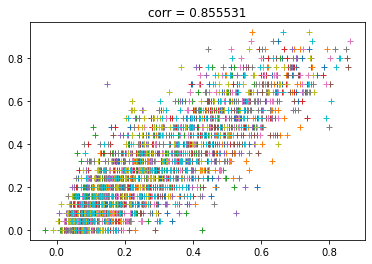

In [57]:
 # define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=123)
cvscores = []

for train, test in kfold.split(X, y):
    cnn6 = Sequential()
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same',input_shape=(X[train].shape[1],X[train].shape[2],X[train].shape[3],1)),)
    cnn6.add(Conv3D(32, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
    cnn6.add(AveragePooling3D(pool_size=2,padding='same'))
    cnn6.add(Dropout(0.2))

    cnn6.add(Flatten())

    cnn6.add(Dense(256, activation='relu'))
    cnn6.add(Dense(units=1, activation = 'linear'))

    adam = keras.optimizers.Adam(lr=0.1)
    cnn6.compile(optimizer='adam', loss='mae',  metrics='accuracy')
    history = cnn6.fit(X[train], y[train], validation_data=(X[test], y[test]), epochs=20)
    yy_test = cnn6.predict(X[test])

    test_corr = np.corrcoef(yy_test[:,0],y[test][:,0])[0,1]
    plt.title('corr = %f'%test_corr)

    plt.plot(yy_test,y[test],'+')
    scores = cnn6.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (cnn6.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("cnn6 Vgg AveragePooling Kernel 32,64 and dropout 0.2 dense 256 lr=0.1")    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) 